## Wprowadzenie

Celem niniejszego dokumentu jest porównanie wyników zwaranych przez algorytm projektujący graf na przestrzeń d-wymiarową. Wyniki algorytmu są prezentowane na wykresie punktowym - w przypadku wartości $d > 2$ wynik algorytmu jest dodatkowo rzutowany na przestrzeń 2-wymiarową za pomocą gotowego algorytmu PCA. 
Dla porównania wyniki algorytmu używającego funkcję scipy.optimize.minimize są zestawione z algorytmem zwracającym podobne wyniki, ale wyznaczający je przy pomocy wartości i wektorów własnych.



In [28]:
import main
np.random.seed(44)

## Porównanie algorytmów

Poniżej porównujemy wyniki algorytmów dla różnych wartości $d$ na reprezentatywnych przykładach - cyklu, grafie sztangowym, oraz grafie Barabasi-Alberta.


Created a cycle graph, with 5 nodes


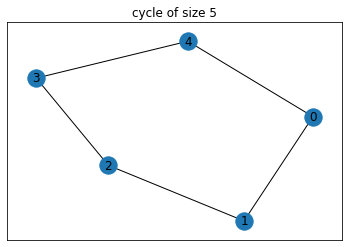

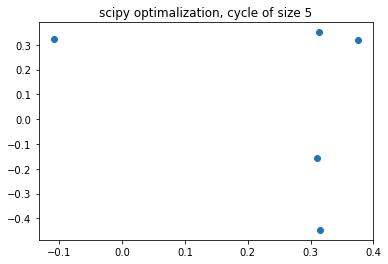

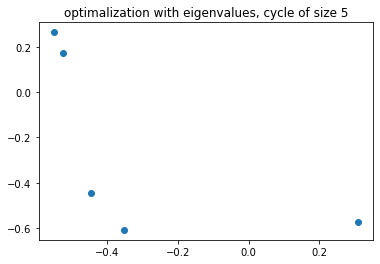

In [6]:
# examples
# two dimensional projection

n = 5
graph = Graph()
graph.cycle_graph(n)
graph.show_results("cycle")

Jak widać w tym przypadku algorytm poradził sobie całkiem dobrze, reprezentacja cyklu o 5 wierzchołkach wygląda poprawnie.

Created a cycle graph, with 5 nodes


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


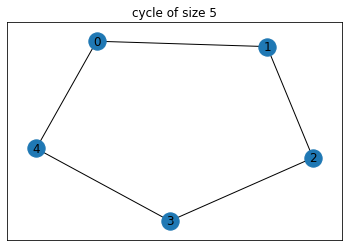

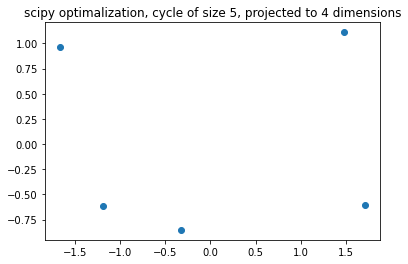

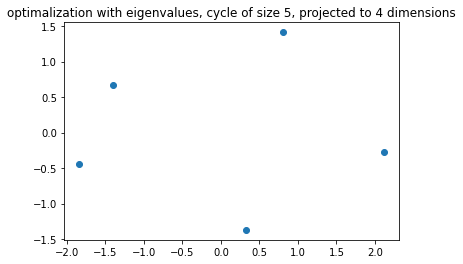

In [8]:
n = 5
graph = Graph()
graph.cycle_graph(n)
graph.show_results("cycle", 4)

Jak się okazuje, w tym przypadku algorytm dla d=4 poradził sobie znacznie lepiej niż wersja z d=2 - w obu przypadkach (algorytmu z scipy.optimize.minimize oraz za pomocą liczenia wartości własnych)

Created a cycle graph, with 10 nodes


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


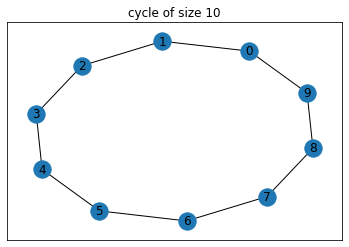

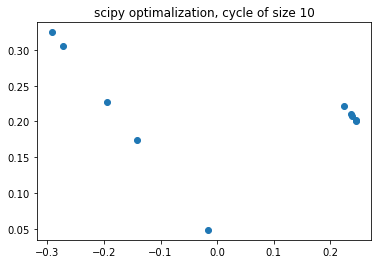

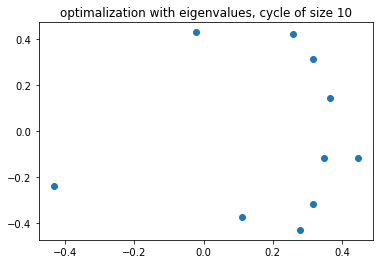

In [16]:
n = 10
graph.cycle_graph(n)
graph.show_results("cycle")

Created a cycle graph, with 10 nodes


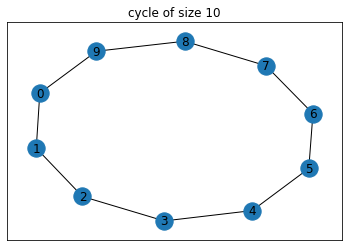

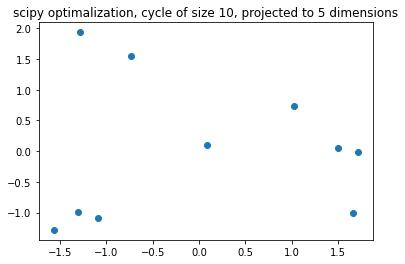

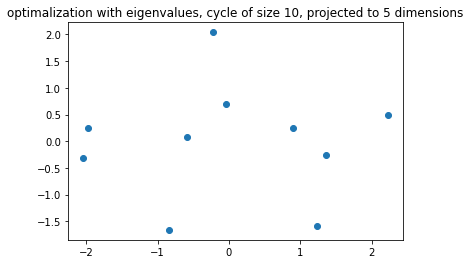

In [17]:
n = 10
graph = Graph()
graph.cycle_graph(n)
graph.show_results("cycle", 5)

Created a cycle graph, with 10 nodes


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


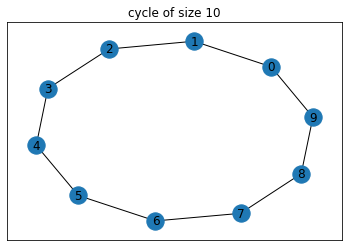

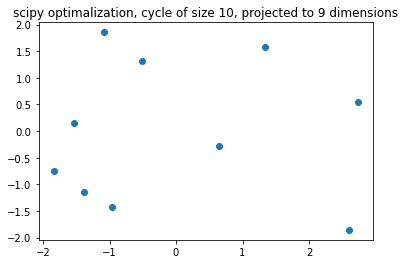

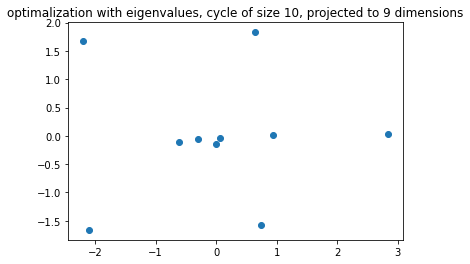

In [18]:
n = 10
graph = Graph()
graph.cycle_graph(n)
graph.show_results("cycle", 9)

W tym przypadku algorytm z d=2 poradził sobie moim zdaniem trochę lepiej niż dla d=5. Mimo długiego czasu wykonywania obliczeń, najlepiej sprawdził się jednak algorytm dla d=9 - mimo drobnych zakłóceń, reprezentacja grafu najbardziej przypomina cykl.

Jeżeli chodzi o optymalizacje przy użyciu wartości własnych najlepiej sprawdził się algorytm dla d=2.

Created a barbell graph, with 5 and 3 nodes


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


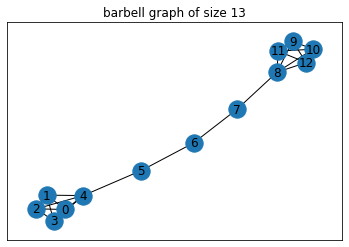

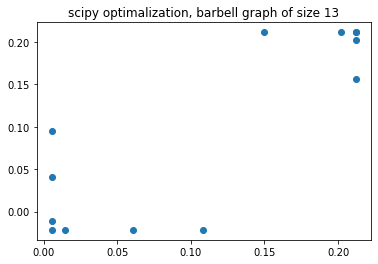

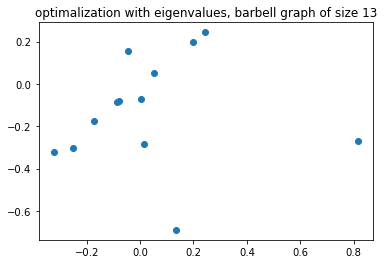

In [19]:
graph.barbell_graph(5, 3)
graph.show_results("barbell graph")

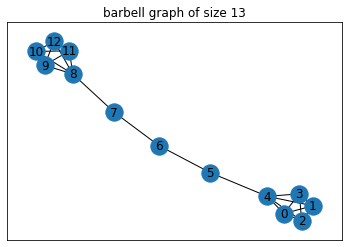

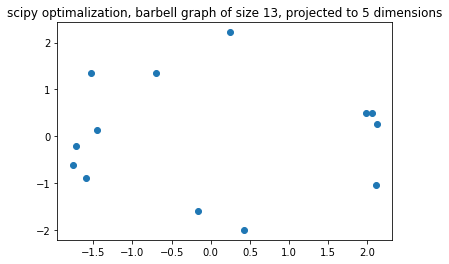

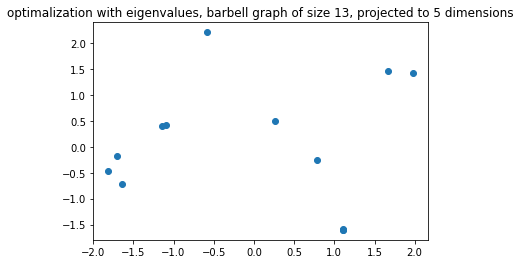

In [20]:
graph.show_results("barbell graph", 5)

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


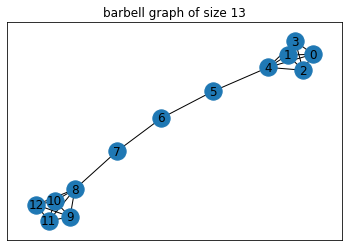

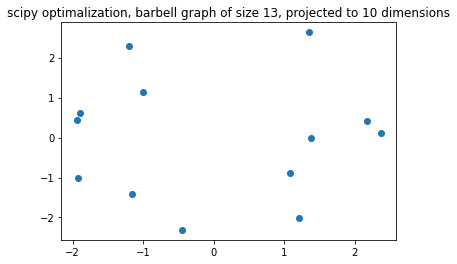

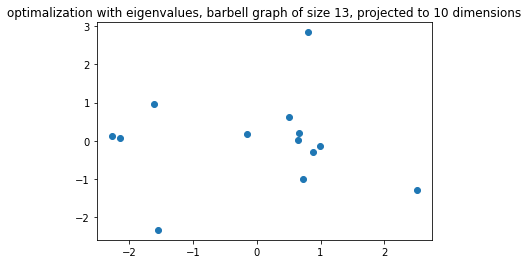

In [21]:
graph.show_results("barbell graph", 10)

W przypadku grafu sztangowego, najlepiej sprawuje się algorytm dla d=2 - na wykresie łatwo zauważyć zgrupowane punktów w dwóch miejscach. Dla większych wartości d nie widać tak wyraźnie zgrupowania. 

Jeżeli chodzi o algorytm wyliczający wartości własne, sprawuje się on raczej gorzej.

Created a ba graph, with 15 nodes


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


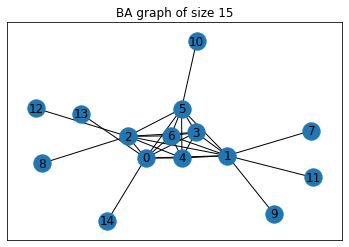

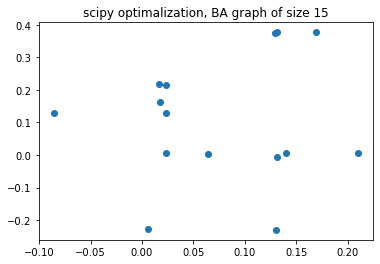

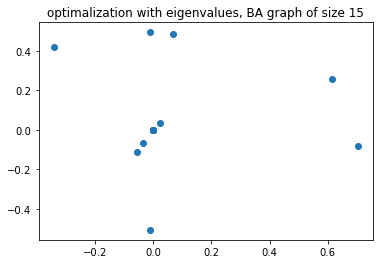

In [22]:
graph.ba_graph(7, 15, 1)
graph.show_results("BA graph")

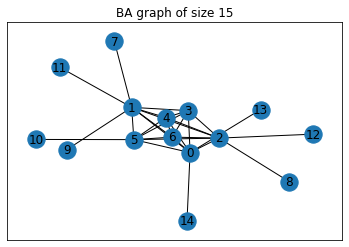

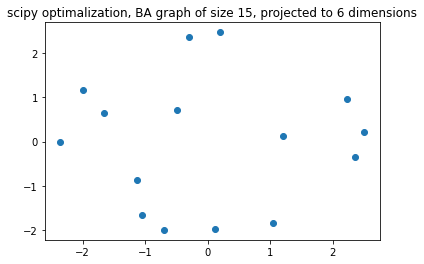

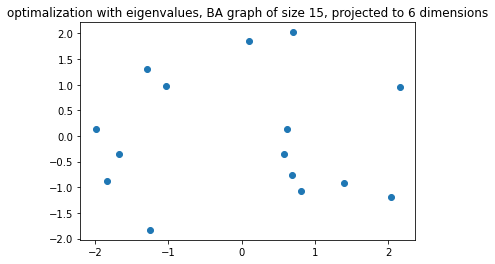

In [23]:
graph.show_results("BA graph", 6)

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


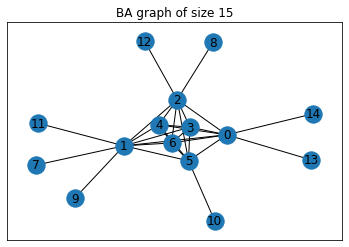

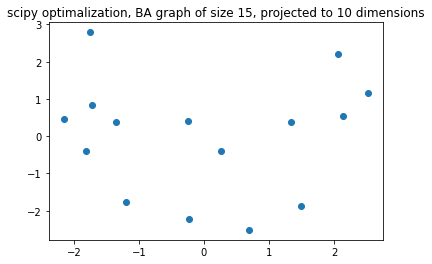

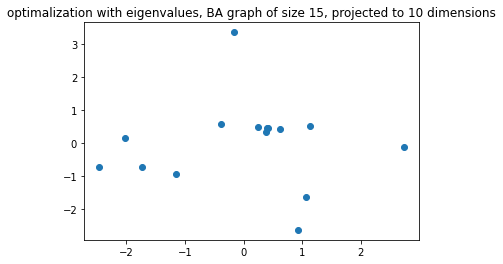

In [24]:
graph.show_results("BA graph", 10)

W przypadku grafu Barabási–Alberta algorytm najlepiej sprawuje się dla d=2 - wyraźnie widać większą grupę punktów w jednym miejscu, czego nie można zaobserwować w pozostałych wizualizacjach. 

W tym przypadku projekcji za pomocą wartości własnych poradziła sobie znacznie lepiej - widać strukturę grafu Barabasi-Alberta. 

## Podsumowanie

W projektowaniu grafów przy użyciu algorytmu korzystającego ze scipy.optimize.minimize najlepsze wyniki są otrzymywane w ogólnym przypadku dla parametru d=2.
Jeżeli chodzi o projektowanie cykli przy użyciu wyżej wspomnianego algorytmu sprawuje się on lepiej dla większych wartości d. 
Wydaję mi się, że jakość wyników dla d > 2 jest zmniejszona ze względu na niedokładność przeprowadzanych obliczeń i stosowane przybliżenia, które zostają dodatkowo spotęgowane przez stosowany algorytm PCA.

Mimo, to wydaje mi się, że zastosowany przeze mnie algorytm sprawuje się lepiej niż wyliczanie wyników za pomocą wartości własnych.